In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from seaborn import pairplot
plt.style.use('ggplot')
%matplotlib inline

# Scenario

We want to see sort different sources of protien into groups based in common characteristics, but how do we group them?
Unlike other scenarios where we knew how many groups we're looking for, here we don't. This calls for hierarchical clustering.
In other words, we'll use a clustering model that will treat each source of protien as a seperate cluster, and start pairing
them together one at a time until we have one big cluster that concludes all sources. Then, we'll be able to decifer how many
groups we have and characterize them. Let's get to it!

First we will load our data set as a DataFrame and take a look at its head.

In [2]:
protiens = pd.read_csv('Proteins.csv')
protiens.head()

,source,energy,protein,fat,iron
0,BEEF BRAISED,340,20,28,2.6
1,HAMBURGER,245,21,17,2.7
2,BEEF ROAST,420,15,39,2.0
3,BEEF STEAK,375,19,32,2.6
4,BEEF CANNED,180,22,10,3.7


Now, a responsible data analyst always checks for missing data prior to modeling. So that's exactly what we're gonna do.

In [3]:
protiens.isnull().values.any()

False

Ok, so are data is intact and all features are numerical as well. which means we can get straight to it.
First and foremost we have to scale our features in order to set their relative distance from  one another.
This will yield a mean = 0 and stadnerd deviation of 1 for each feature in our data set. We'll be scaling via the scale method
to get our Z distributions.

In [4]:
z_protiens = scale(protiens.iloc[:,1:])
z_protiens = pd.DataFrame(z_protiens, columns=['energy', 'protein', 'fat', 'iron'], index=protiens['source'])
z_protiens.head()

,energy,protein,fat,iron
source,,,,
BEEF BRAISED,1.301595,0.264987,1.278470,0.152676
HAMBURGER,0.361554,0.502561,0.298195,0.221117
BEEF ROAST,2.093208,-0.922884,2.258744,-0.257970
BEEF STEAK,1.647925,0.027412,1.634933,0.152676
BEEF CANNED,-0.281632,0.740135,-0.325616,0.905527


In [5]:
round(z_protiens.mean(axis=0), 1)

energy     0.0
protein    0.0
fat        0.0
iron       0.0
dtype: float64

In [6]:
round(z_protiens.std(axis=0), 1)

energy     1.0
protein    1.0
fat        1.0
iron       1.0
dtype: float64

So now that our data is scaled properly, we would like to know the euclidean distance between each source to all other sorces.
We can build a matrix via built-in Scipy functions. We'll take a look at the distance between Hamburger and Beef Steak
as an example.

In [7]:
distances = pdist(z_protiens, metric='euclidean')
DistMatrix = squareform(distances)
# Alternate way to get all distances.
dist = np.sqrt(sum((a-b)**2 for a,b in zip(z_protiens.ix[1], z_protiens.ix[3])))
print(dist, DistMatrix[1][3])

1.91626438452 1.91626438452


Alright, all is set and we're ready to fit our model onto the data set. We'll be using the ward method for our model.
Also, we should visualize our data via a Dendrogram to see the groups.

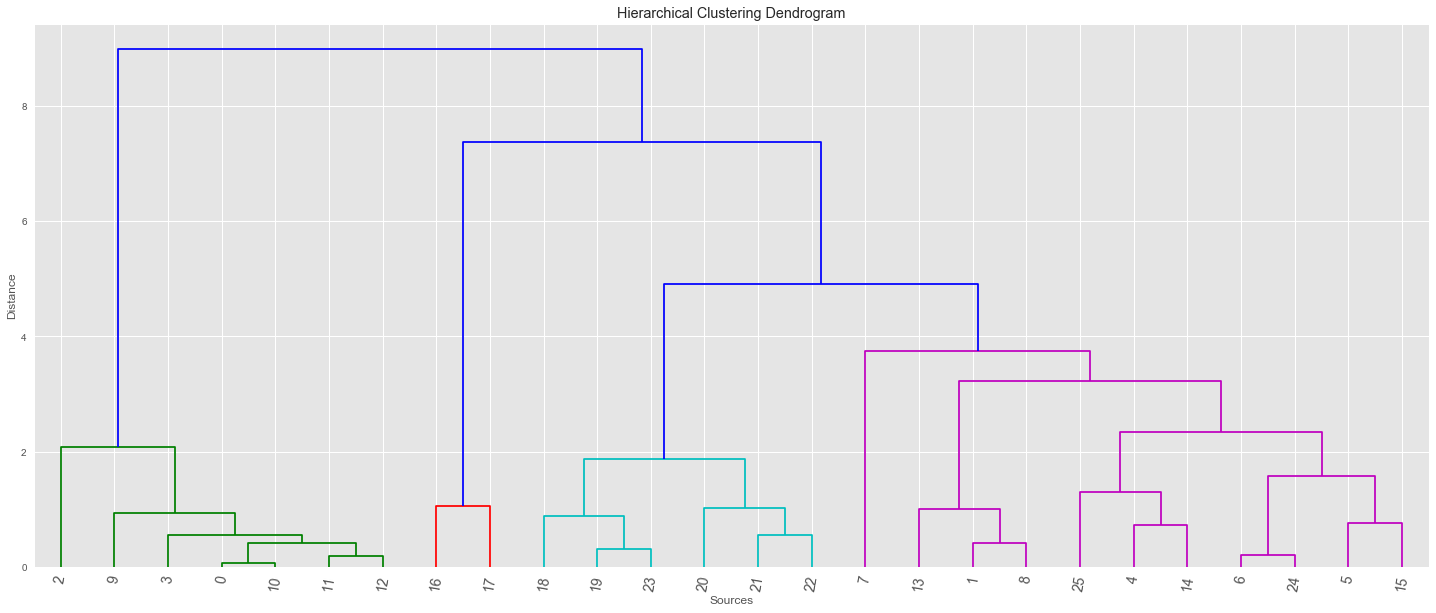

In [8]:
# Fitting our model.
cluster_tree = linkage(z_protiens, 'ward')

# Ploting our dendrogram.
colors = ['g', 'b', 'r', 'p', 'y']
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sources')
plt.ylabel('Distance')

dendrogram(cluster_tree, leaf_rotation=80., leaf_font_size=14.,  color_threshold=4.5)

plt.show()

Ok, as we can see there are 4 different groups(clusters) of Sources. Each Source was linked to the clossest one to it, and the
proccess continued until all porints were conncected.

If we look at our model we can which points were connected and at what distance. We have 26 Sources, so there are 25 
connections. The model indicies are as follows [group1, group2, Linkage Height, cluster size].

For instance, proteins[0] & protiens[10] merged in the first level, at level 12 proteins[13] with proteins[31].
wait what?! We said there are 26 sources so how can there be index 31..?

As we stated before, the data points continuesly merge into groups. This means that eventually single data points will merge
with GROUPS and groups with other groups, until all is one. To show this, our model will return a (n−1) by 4 matrix "Z". At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n+i. A cluster with an index less than n corresponds to one of the n original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.

In [9]:
cluster_tree

array([[  0.        ,  10.        ,   0.06844096,   2.        ],
       [ 11.        ,  12.        ,   0.18616259,   2.        ],
       [  6.        ,  24.        ,   0.20532289,   2.        ],
       [ 19.        ,  23.        ,   0.31178339,   2.        ],
       [ 26.        ,  27.        ,   0.41110105,   4.        ],
       [  1.        ,   8.        ,   0.41444674,   2.        ],
       [ 21.        ,  22.        ,   0.55275083,   2.        ],
       [  3.        ,  30.        ,   0.56327253,   5.        ],
       [  4.        ,  14.        ,   0.73160613,   2.        ],
       [  5.        ,  15.        ,   0.756743  ,   2.        ],
       [ 18.        ,  29.        ,   0.87989602,   3.        ],
       [  9.        ,  33.        ,   0.94148148,   6.        ],
       [ 13.        ,  31.        ,   1.01252331,   3.        ],
       [ 20.        ,  32.        ,   1.02133295,   3.        ],
       [ 16.        ,  17.        ,   1.06437332,   2.        ],
       [ 25.        ,  34

Breaking it down. Frist, Source 0 (Beef Braised) was merged with Source 10 (Smoked Ham) at the distance of 0.06844096

In [10]:
cluster_tree[0]

array([  0.        ,  10.        ,   0.06844096,   2.        ])

At level 12, Source 13 (Beef Tongue) was merged with Sources (Hamburger, Lamb Leg Roast) at the distance of 0.06844096

In [11]:
cluster_tree[12]

array([ 13.        ,  31.        ,   1.01252331,   3.        ])

Finally, we can see that all 26 Sources merged together into one big group.

In [12]:
cluster_tree[-1]

array([ 44.        ,  49.        ,   8.97753648,  26.        ])

Ok, time to assign each Source to it's cluster.
We can see above that there is a great increase in distance between cluster_tree[21] & cluster_tree[22]. So that's where we
should cut our dendrogram (as did earlier with color_threshold=4.5) at 4.5

In [13]:
max_distance = 4.5
clusters = fcluster(cluster_tree, max_distance, criterion='distance')
clusters

array([1, 4, 1, 1, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 2, 2, 3, 3, 3, 3, 3,
       3, 4, 4], dtype=int32)

In [14]:
protiens['cluster'] = clusters
protiens.head()

,source,energy,protein,fat,iron,cluster
0,BEEF BRAISED,340,20,28,2.6,1
1,HAMBURGER,245,21,17,2.7,4
2,BEEF ROAST,420,15,39,2.0,1
3,BEEF STEAK,375,19,32,2.6,1
4,BEEF CANNED,180,22,10,3.7,4


Alright, now that we assigend the Sources to clusters we can start analyzing!

Lets see the sizes of our clusters.

In [15]:
protiens['cluster'].value_counts()

4    11
1     7
3     6
2     2
Name: cluster, dtype: int64

Ok, let's see how the clusters differentiate from one another.

In [16]:
protiens_mean = protiens.groupby('cluster').mean()
protiens_mean

,energy,protein,fat,iron
cluster,,,,
1,352.857143,18.571429,30.142857,2.414286
2,57.500000,9.000000,1.000000,5.700000
3,149.166667,16.333333,7.500000,1.016667
4,176.363636,22.272727,8.818182,2.490909


Ok, Lets bar plot our features by their mean value and see what we're looking at.

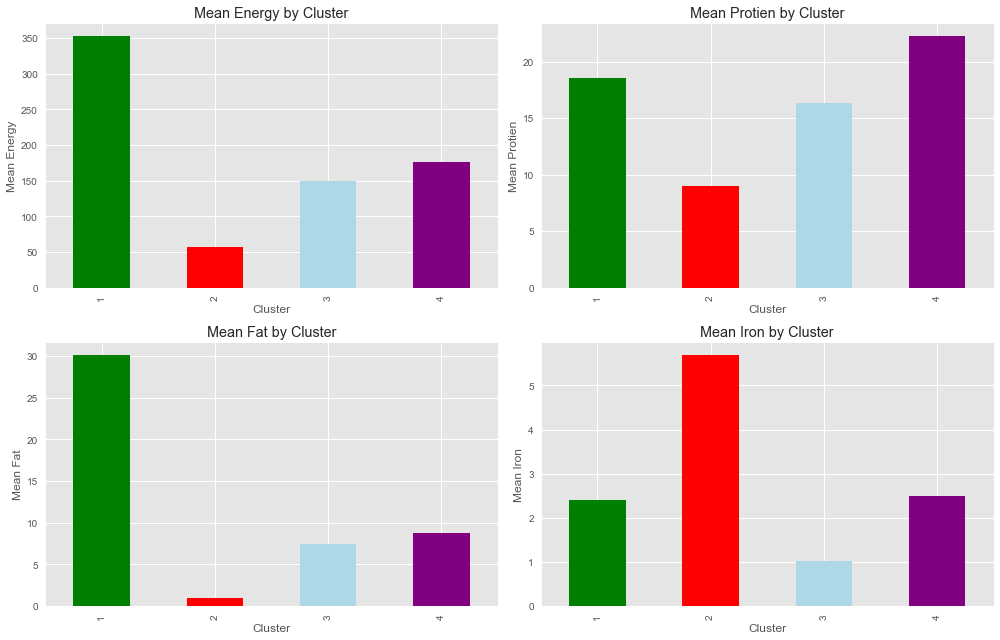

In [17]:
fig, ax1, ax2, ax3, ax4 = plt.figure(figsize=(14,9)), plt.subplot2grid((2,2), (0,0)), plt.subplot2grid((2,2), (0,1)),\
                                    plt.subplot2grid((2,2), (1,0)), plt.subplot2grid((2,2), (1,1))

colors = ['g', 'r', 'lightblue', 'purple']
    
protiens_mean['energy'].plot(kind='bar', ax=ax1, title='Mean Energy by Cluster', color=colors)
ax1.set_ylabel('Mean Energy')
ax1.set_xlabel('Cluster')

protiens_mean['protein'].plot(kind='bar', ax=ax2, title='Mean Protien by Cluster', color=colors)
ax2.set_ylabel('Mean Protien')
ax2.set_xlabel('Cluster')

protiens_mean['fat'].plot(kind='bar', ax=ax3, title='Mean Fat by Cluster', color=colors)
ax3.set_ylabel('Mean Fat')
ax3.set_xlabel('Cluster')

protiens_mean['iron'].plot(kind='bar', ax=ax4, title='Mean Iron by Cluster', color=colors)
ax4.set_ylabel('Mean Iron')
ax4.set_xlabel('Cluster')

plt.tight_layout()

We should also look at a pair plot to see how the clusters differ from one another.

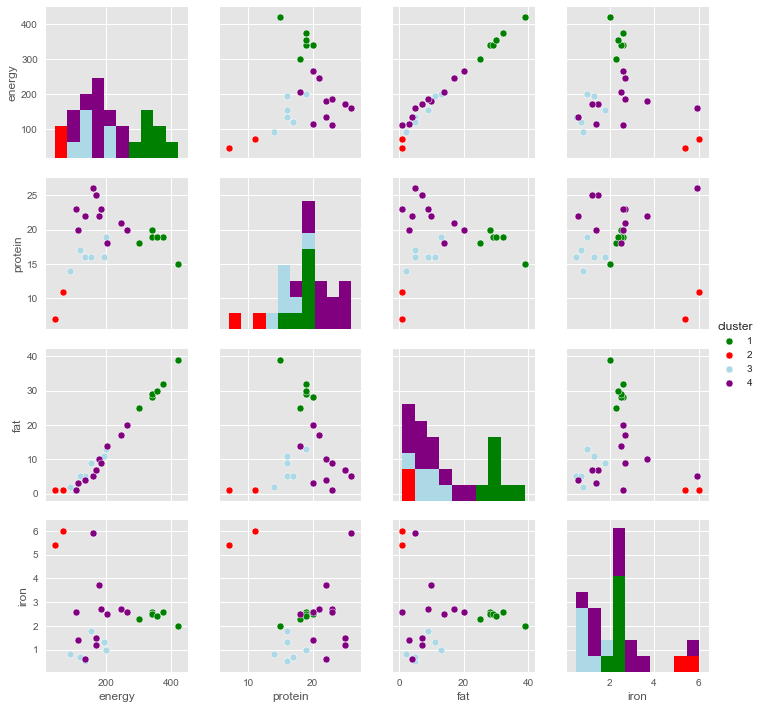

In [18]:
pairplot(protiens, hue='cluster', palette=colors, vars=['energy', 'protein', 'fat','iron'])

Cluster 1 seems to consist of all the smoked and roasted red meets. high in fat, protiens and energy.

In [19]:
protiens[(protiens['cluster'] == 1)]

,source,energy,protein,fat,iron,cluster
0,BEEF BRAISED,340,20,28,2.6,1
2,BEEF ROAST,420,15,39,2.0,1
3,BEEF STEAK,375,19,32,2.6,1
9,LAMB SHOULDER ROAST,300,18,25,2.3,1
10,SMOKED HAM,340,20,28,2.5,1
11,PORK ROAST,340,19,29,2.5,1
12,PORK SIMMERED,355,19,30,2.4,1


Cluster 2 seems to consist of clams. high in iron but low on the rest.

In [20]:
protiens[(protiens['cluster'] == 2)]

,source,energy,protein,fat,iron,cluster
16,CLAMS RAW,70,11,1,6.0,2
17,CLAMS CANNED,45,7,1,5.4,2


Cluster 3 seems to consist of all the the fish sources of protien. pretty average amongst the other clusters.

In [21]:
protiens[(protiens['cluster'] == 3)]

,source,energy,protein,fat,iron,cluster
18,CRABMEAT CANNED,90,14,2,0.8,3
19,HADDOCK FRIED,135,16,5,0.5,3
20,MACKEREL BROILED,200,19,13,1.0,3
21,MACKEREL CANNED,155,16,9,1.8,3
22,PERCH FRIED,195,16,11,1.3,3
23,SALMON CANNED,120,17,5,0.7,3


Cluster 4 seems to consist of high sources of protien while pretty average on the rest of the features.
In other words, your casual sources of protien.

In [22]:
protiens[(protiens['cluster'] == 4)]

,source,energy,protein,fat,iron,cluster
1,HAMBURGER,245,21,17,2.7,4
4,BEEF CANNED,180,22,10,3.7,4
5,CHICKEN BROILED,115,20,3,1.4,4
6,CHICKEN CANNED,170,25,7,1.5,4
7,BEEF HEART,160,26,5,5.9,4
8,LAMB LEG ROAST,265,20,20,2.6,4
13,BEEF TONGUE,205,18,14,2.5,4
14,VEAL CUTLET,185,23,9,2.7,4
15,BLUEFISH BAKED,135,22,4,0.6,4
24,TUNA CANNED,170,25,7,1.2,4
